# Modeling

In [49]:
#Libs
import os
import warnings
import pickle
import optuna
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from utils.features.build import build_distance, build_hour_group
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from ngboost import NGBRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from ngboost.distns import Exponential, Normal, LogNormal
from dotenv import load_dotenv, find_dotenv
from utils.models.evaluate import plot_learning_curve, plot_permutation_importance
from utils.models.predict_model import get_intervals
warnings.filterwarnings('ignore')

In [50]:
# Env variables and data
load_dotenv(find_dotenv())
DATA_INPUT_PATH = os.getenv('DATA_PROCESSED_PATH')
DATA_TRAIN_NAME = 'train_best_features'
DATA_TEST_NAME = 'test'
DATA_SUBMISSION = 'submission'
MODEL_PATH = os.getenv('MODEL_PATH')
# Data
df_orders_train = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_TRAIN_NAME))
df_orders_test = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_TEST_NAME))
df_submission = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_SUBMISSION))

# 1) Modeling

In this step We'll try 3 approaches to solve the problem:
- Linear Regression 
- Random Forest 
- NGBoost 

With Linear Regression We intend to create a baseline to be beaten. We'll observe performance in terms of Mean Absolute Percentage Error and Proportion of overestimated predictions. 
The former metric will be better if It approaches 0, the latter will be better if When model gets It wrong, the model overestimates instead of underestimate. We wish this property because When the model underestimate, the order will be late, and It is better to be early than late. As We saw in Exploratory Data Analysis, the `total_minutes` distribution has a long tail, so It may be import to apply logarithm in order to relieve the impact of outliers.

In [3]:
# Separating X and y for training
X_train = df_orders_train.drop('total_minutes', axis=1)
y_train = df_orders_train['total_minutes']
# list with all columns
all_columns = X_train.columns.tolist()

## 1.1) Preprocessing

In [4]:
# We will have 3 imputers: Median for some numerical, Mode for categorical and 0 for some numerical
median_impute_columns_indexes = [all_columns.index(x) for x in ['n_distinct_items', 'distance_km', 'found_rate']]
mode_impute_columns_indexes = [all_columns.index(x) for x in ['on_demand', 'hour_group']]
zero_impute_columns_indexes = [all_columns.index(x) for x in ['sum_kgs', 'sum_unities']]
cat_columns = df_orders_train.select_dtypes(include=['O']).columns.tolist()
cat_columns_indexes = [all_columns.index(x) for x in cat_columns]
num_columns = df_orders_train.drop('total_minutes', axis=1).select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.tolist()
num_columns_indexes = [all_columns.index(x) for x in num_columns]
impute_median_columns = ['n_distinct_items', 'distance_km', 'found_rate']
impute_zero_columns = ['sum_kgs', 'sum_unities']
# Feature engineering steps
distance_transformer = FunctionTransformer(func=build_distance)
hour_group_transformer = FunctionTransformer(func=build_hour_group)
pipe_feature_engineering = Pipeline(steps=[('distance_transformer', distance_transformer),
                                           ('hor_group_transformer', hour_group_transformer)])
# Imputation Steps

impute_median = Pipeline([('impute_median', SimpleImputer(strategy='median'))])
impute_mode = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent'))])
impute_zero = Pipeline([('impute_zero', SimpleImputer(strategy='constant', fill_value=0))])
one_hot = Pipeline([('cat_encoder', OneHotEncoder(handle_unknown='ignore'))])
cat_transformer= Pipeline([('impute_mode', impute_mode),                                
                           ('one_hot', one_hot)])
preprocessor = ColumnTransformer([('impute_mode_one_hot', cat_transformer, cat_columns),
                                      ('impute_median', impute_median, impute_median_columns),
                                      ('impute_zero', impute_zero, impute_zero_columns)])


## 1.2) Baseline

Our baseline will be a Linear Regression.

In [6]:
# Pipeline with preprocessor and Model
model_baseline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))])

In [7]:
# Performing a 10-Fold cross validation to get an estimate for MAE and MAPE
df_baseline_cv_metrics = pd.DataFrame(cross_validate(model_baseline,
                                        X_train,
                                        y_train, 
                                        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                                        return_train_score=True, cv=10))

In [8]:
df_baseline_cv_metrics

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.028925,0.007145,-20.022554,-20.415693,-0.265349,-0.267731
1,0.031672,0.010745,-19.512231,-20.478940,-0.262205,-0.268664
2,0.025328,0.008022,-20.663146,-20.334302,-0.270654,-0.267280
3,0.019351,0.007095,-19.108091,-20.530233,-0.247190,-0.269626
4,0.016797,0.006401,-20.154597,-20.398224,-0.280051,-0.267034
5,0.018591,0.008016,-21.316906,-20.262441,-0.266537,-0.267155
6,0.018770,0.006258,-20.798057,-20.336376,-0.271078,-0.267501
7,0.018125,0.007997,-21.100928,-20.275357,-0.276072,-0.266705
8,0.019429,0.006332,-20.361290,-20.383473,-0.269171,-0.267875
9,0.015115,0.006755,-21.155491,-20.292296,-0.274145,-0.266546


In [9]:
model_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('impute_mode_one_hot',
                                                  Pipeline(steps=[('impute_mode',
                                                                   Pipeline(steps=[('impute_mode',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('one_hot',
                                                                   Pipeline(steps=[('cat_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]))]),
                                                  ['on_demand', 'hour_group']),
                                                 ('impute_median',
                                                  Pipeline(steps=[('impute_median',
                                              

Let's see average MAPE and Standard Deviation of MAPE.

In [10]:
print(f"Average MAPE - Cross Validation Test: {df_baseline_cv_metrics['test_neg_mean_absolute_percentage_error'].mean()}")
print(f"Standard Deviation of MAPE - Cross Validation Test: {df_baseline_cv_metrics['test_neg_mean_absolute_percentage_error'].std()}")

Average MAPE - Cross Validation Test: -0.26824515384366066
Standard Deviation of MAPE - Cross Validation Test: 0.009075169386691588


So, nn average, the model is wrong by 26.8%. It means that for an order that will take 100 minutes to finish, It tends to predict either 127 or 73 minutes.

Also, We need to see if the predictions are higher or lower than the real value. It's better to overestimate the time, because the order will not be late. Let's check what happens more in our case, overestimate or underestimate.

In [11]:
# Generating predictions for X_train
y_train_baseline_predict = model_baseline.predict(X_train)
# Calculating proportion of overestimation
print(f'About {((y_train_baseline_predict >= y_train).sum())/len(y_train)*100}% of our predictions are higher than the real value')

About 51.33333333333333% of our predictions are higher than the real value


## 1.2) Random Forest

As a challenger to the baseline, We will train a Random Forest Regressor with Bayesian Optimization to tuning the hyperparameters. This model will have higher variance compared to Linear Regression and We'll focus on improving MAPE and also try to improve the rate of overestimated orders.

In [12]:
# Hyperparameter tuning using optuna 
def objective(trial):
    params = {'model__regressor__max_depth':trial.suggest_int('max_depth', 1, 10),
              'model__regressor__max_leaf_nodes':trial.suggest_int('max_leaf_nodes', 600, 1000),
              'model__regressor__n_estimators':trial.suggest_int('n_estimators', 30, 1000)}
    
    model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', TransformedTargetRegressor(RandomForestRegressor(random_state=123), func=np.log, inverse_func=np.exp))])
    model_rf.set_params(**params)   
    score = cross_val_score(model_rf, X_train, np.log(y_train), cv=5, scoring='neg_mean_squared_error')
    mse = score.mean()

    return mse
sampler = TPESampler(multivariate=True)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=50)


[I 2021-12-08 20:49:28,665] A new study created in memory with name: no-name-a674b956-0aaa-4b60-9ecc-4a28d3dd1935
[I 2021-12-08 20:49:52,503] Trial 0 finished with value: -0.10527233423177336 and parameters: {'max_depth': 5, 'max_leaf_nodes': 695, 'n_estimators': 896}. Best is trial 0 with value: -0.10527233423177336.
[I 2021-12-08 20:50:00,956] Trial 1 finished with value: -0.10404329702450399 and parameters: {'max_depth': 7, 'max_leaf_nodes': 768, 'n_estimators': 241}. Best is trial 1 with value: -0.10404329702450399.
[I 2021-12-08 20:50:07,195] Trial 2 finished with value: -0.10527876144281725 and parameters: {'max_depth': 5, 'max_leaf_nodes': 903, 'n_estimators': 223}. Best is trial 1 with value: -0.10404329702450399.
[I 2021-12-08 20:50:19,524] Trial 3 finished with value: -0.10425451776810975 and parameters: {'max_depth': 6, 'max_leaf_nodes': 866, 'n_estimators': 412}. Best is trial 1 with value: -0.10404329702450399.
[I 2021-12-08 20:50:22,032] Trial 4 finished with value: -0.12

In [13]:
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', RandomForestRegressor(random_state=123))])
model_rf['model'].set_params(**study.best_params)
df_rf_cv_metrics = pd.DataFrame(cross_validate(model_rf,
                                        X_train,
                                        y_train, 
                                        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                                        return_train_score=True, cv=10))

In [14]:
df_rf_cv_metrics

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,2.578422,0.043047,-19.755650,-18.294765,-0.276865,-0.256919
1,2.599762,0.044312,-19.484809,-18.328173,-0.278720,-0.257886
2,2.634121,0.041394,-20.749369,-18.166565,-0.285864,-0.255367
3,2.563715,0.043085,-18.585874,-18.424362,-0.257024,-0.259352
4,2.581132,0.041065,-20.058745,-18.227328,-0.292076,-0.256293
5,2.567649,0.044509,-20.456459,-18.211820,-0.273080,-0.257228
6,2.571286,0.051227,-20.879538,-18.179255,-0.290557,-0.255411
7,2.557800,0.041285,-20.912159,-18.183693,-0.288831,-0.255878
8,2.522886,0.043346,-19.776110,-18.280314,-0.278725,-0.257278
9,2.526025,0.053432,-20.441183,-18.153994,-0.280869,-0.255582


In [15]:
print(f"Average MAPE - Cross Validation Test: {df_rf_cv_metrics['test_neg_mean_absolute_percentage_error'].mean()}")
print(f"Standard Deviation of MAPE - Cross Validation Test: {df_rf_cv_metrics['test_neg_mean_absolute_percentage_error'].std()}")

Average MAPE - Cross Validation Test: -0.28026104424121495
Standard Deviation of MAPE - Cross Validation Test: 0.010320406224479894


In [16]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('impute_mode_one_hot',
                                                  Pipeline(steps=[('impute_mode',
                                                                   Pipeline(steps=[('impute_mode',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('one_hot',
                                                                   Pipeline(steps=[('cat_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]))]),
                                                  ['on_demand', 'hour_group']),
                                                 ('impute_median',
                                                  Pipeline(steps=[('impute_median',
                                              

In [17]:
# Generating predictions for X_train
y_train_rf_predict = model_rf.predict(X_train)
# Calculating proportion of overestimation
print(f'About {((y_train_rf_predict >= y_train).sum())/len(y_train)*100}% of our predictions are higher than the real value')

About 57.116666666666674% of our predictions are higher than the real value


We see that, despite MAPE is a little worse compared to the baseline, the proportion of overestimated predictions is higher.

## 1.3) NGBoost 

Finally, We'll train a NGBoost model, which is capable of outputing a distribution for each prediction, so that We'll be able to calculate prediction interval, what can be really useful in production enviroment, because Cornershop can now give an interval, instead of a point estimation for the time the order will take to complete.

In [18]:
model_nb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model',NGBRegressor(Base=DecisionTreeRegressor(max_depth=5, min_samples_leaf=600,random_state=123),
                                                 random_state=123,
                                                Dist=LogNormal))])
df_rf_nb_metrics = pd.DataFrame(cross_validate(model_nb,
                                        X_train,
                                        y_train, 
                                        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                                        return_train_score=True, cv=10))

[iter 0] loss=4.8731 val_loss=0.0000 scale=1.0000 norm=0.6300
[iter 100] loss=4.6717 val_loss=0.0000 scale=1.0000 norm=0.5447
[iter 200] loss=4.5897 val_loss=0.0000 scale=1.0000 norm=0.5485
[iter 300] loss=4.5594 val_loss=0.0000 scale=1.0000 norm=0.5618
[iter 400] loss=4.5485 val_loss=0.0000 scale=1.0000 norm=0.5678
[iter 0] loss=4.8759 val_loss=0.0000 scale=1.0000 norm=0.6297
[iter 100] loss=4.6766 val_loss=0.0000 scale=1.0000 norm=0.5445
[iter 200] loss=4.5975 val_loss=0.0000 scale=1.0000 norm=0.5475
[iter 300] loss=4.5662 val_loss=0.0000 scale=1.0000 norm=0.5597
[iter 400] loss=4.5549 val_loss=0.0000 scale=2.0000 norm=1.1334
[iter 0] loss=4.8676 val_loss=0.0000 scale=1.0000 norm=0.6267
[iter 100] loss=4.6655 val_loss=0.0000 scale=1.0000 norm=0.5406
[iter 200] loss=4.5803 val_loss=0.0000 scale=1.0000 norm=0.5465
[iter 300] loss=4.5531 val_loss=0.0000 scale=1.0000 norm=0.5593
[iter 400] loss=4.5430 val_loss=0.0000 scale=2.0000 norm=1.1300
[iter 0] loss=4.8758 val_loss=0.0000 scale=1.0

In [19]:
df_rf_nb_metrics

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,12.631492,0.112894,-19.877955,-19.931487,-0.276375,-0.274594
1,12.659264,0.118663,-19.136172,-20.036376,-0.271892,-0.276238
2,12.139647,0.108349,-21.170471,-19.800007,-0.286607,-0.273285
3,11.838704,0.108441,-18.852807,-20.015819,-0.257770,-0.276485
4,12.296865,0.104802,-20.453957,-19.853026,-0.293276,-0.273466
5,12.243917,0.114186,-20.642691,-19.814938,-0.272081,-0.274633
6,12.697415,0.113073,-20.981803,-19.835037,-0.289344,-0.273698
7,12.604541,0.105242,-21.062606,-19.815347,-0.291492,-0.273370
8,12.602217,0.109197,-19.987676,-19.921240,-0.280282,-0.275080
9,12.422642,0.117842,-20.875762,-19.820506,-0.284186,-0.273671


In [20]:
print(f"Average MAPE - Cross Validation Test: {df_rf_nb_metrics['test_neg_mean_absolute_percentage_error'].mean()}")
print(f"Standard Deviation of MAPE - Cross Validation Test: {df_rf_nb_metrics['test_neg_mean_absolute_percentage_error'].std()}")

Average MAPE - Cross Validation Test: -0.2803305443860043
Standard Deviation of MAPE - Cross Validation Test: 0.011013031804846442


In [21]:
model_nb.fit(X_train, y_train)


[iter 0] loss=4.8702 val_loss=0.0000 scale=1.0000 norm=0.6286
[iter 100] loss=4.6638 val_loss=0.0000 scale=1.0000 norm=0.5410
[iter 200] loss=4.5812 val_loss=0.0000 scale=2.0000 norm=1.0922
[iter 300] loss=4.5515 val_loss=0.0000 scale=1.0000 norm=0.5613
[iter 400] loss=4.5426 val_loss=0.0000 scale=2.0000 norm=1.1339


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('impute_mode_one_hot',
                                                  Pipeline(steps=[('impute_mode',
                                                                   Pipeline(steps=[('impute_mode',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('one_hot',
                                                                   Pipeline(steps=[('cat_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]))]),
                                                  ['on_demand', 'hour_group']),
                                                 ('impute_median',
                                                  Pipeline(steps=[('impute_...
                                                 ('

In [22]:
y_train_nb_predict = model_nb.predict(X_train)
print(f'About {((y_train_nb_predict >= y_train).sum())/len(y_train)*100}% of our predictions are higher than the real value')

About 57.41666666666667% of our predictions are higher than the real value


To generate prediction interval, We'll need to apply `.pred_dist()` method and then extract the distribution parameters for each prediction.

In [23]:
# preprocessing step
X_train_preprocessed = model_nb['preprocessor'].transform(X_train)
# get parameters 
y_train_prob = model_nb['model'].pred_dist(X_train_preprocessed).params
predictions = pd.DataFrame(y_train_prob)


In [24]:
predictions

,s,scale
0,0.390934,44.356750
1,0.260647,123.058273
2,0.408346,56.740349
3,0.234675,107.306261
4,0.330448,84.836854
...,...,...
5995,0.338832,55.881411
5996,0.327237,75.126496
5997,0.394121,48.546872
5998,0.292796,71.703699


For each row We have `s` and `scale` values. As We defined the target to have a normal distribution, We can apply these parameters and get the interval using `scipy`

In [25]:

#create 95% confidence interval 
predictions['interval'] = predictions.apply(lambda x: st.lognorm.interval(alpha=0.95, s=x['s'], scale=x['scale']), axis=1)


In [73]:
pd.DataFrame(predictions.loc[0,:]).T['interval'][0]

(20.615620568217647, 95.43837093908799)

Note that the interval is pretty large in some cases, which says that We need more data and more features to accomplish the task completely

NGBoost performed worse than `Random Forest Regressor` and `Linear Regression` comparing `MAPE`. When It comes `Overestimation Rate`, NGBoost is the best model. Because the differente in MAPE is not so large between models and Overestimation Rate can impact a lot in User Journey/Experience, We will choose NGBoost. Besides, NGBoost is able to give distributions instead of point estimates, so We'll be able to estimate confidence intervals, that may be more suitable in delivery applications.

# 2) Evaluation

### 2.1) Learning Curve

[iter 0] loss=4.8250 val_loss=0.0000 scale=512.0000 norm=316.1187
== Quitting at iteration / GRAD 0
[iter 0] loss=4.8493 val_loss=0.0000 scale=1.0000 norm=0.6324
[iter 100] loss=4.7143 val_loss=0.0000 scale=2.0000 norm=1.1536
[iter 200] loss=4.6614 val_loss=0.0000 scale=1.0000 norm=0.5800
[iter 300] loss=4.6381 val_loss=0.0000 scale=2.0000 norm=1.1670
[iter 400] loss=4.6246 val_loss=0.0000 scale=2.0000 norm=1.1710
[iter 0] loss=4.8654 val_loss=0.0000 scale=1.0000 norm=0.6309
[iter 100] loss=4.6833 val_loss=0.0000 scale=1.0000 norm=0.5537
[iter 200] loss=4.6179 val_loss=0.0000 scale=1.0000 norm=0.5533
[iter 300] loss=4.5859 val_loss=0.0000 scale=1.0000 norm=0.5620
[iter 400] loss=4.5711 val_loss=0.0000 scale=1.0000 norm=0.5693
[iter 0] loss=4.8773 val_loss=0.0000 scale=1.0000 norm=0.6323
[iter 100] loss=4.6774 val_loss=0.0000 scale=1.0000 norm=0.5478
[iter 200] loss=4.5970 val_loss=0.0000 scale=2.0000 norm=1.1042
[iter 300] loss=4.5677 val_loss=0.0000 scale=1.0000 norm=0.5653
[iter 400]

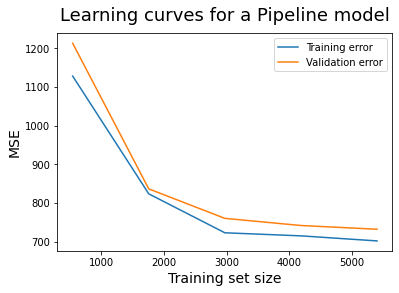

In [27]:
plot_learning_curve(model_nb, X_train, y_train, 10, scoring='neg_mean_squared_error')

From the Learning Cruve, It seems that validation error and Training error did not reache the minimum error yet, which means more data would be useful in this case. Furthermore, maybe more features help to improve performance as well.
If this model was going to be put into production, We would have to wait to get more data in order to start the retraining system.

### 2.2) Permutation Importance

In [28]:
# Just saving name of features after transformers
one_hot_names = model_nb.steps[0][1].transformers_[0][1][1].get_feature_names_out().tolist()
median_names = model_nb.steps[0][1].transformers_[1][1][0].feature_names_in_.tolist()
zero_names = model_nb.steps[0][1].transformers_[2][1][0].feature_names_in_.tolist()
columns_after_transformation = one_hot_names+median_names+zero_names

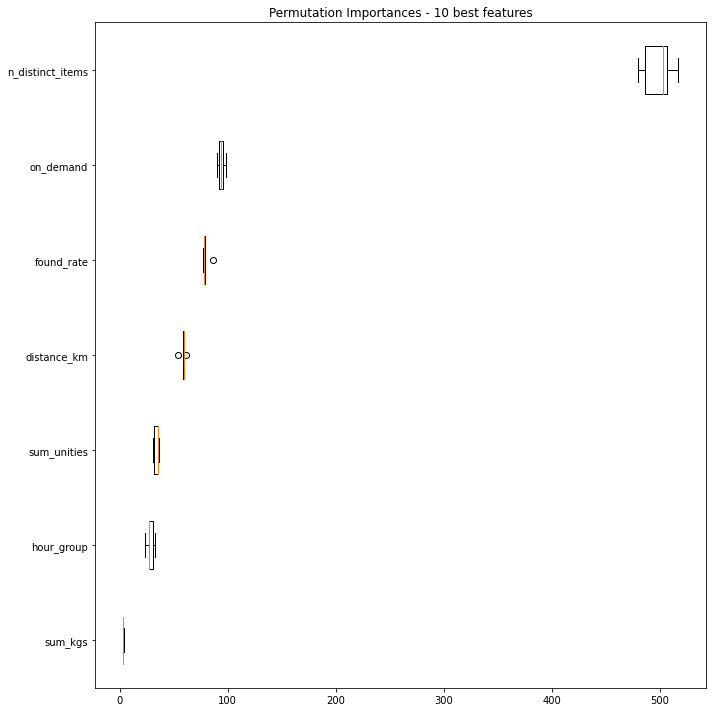

In [29]:
plot_permutation_importance(model_nb, X=X_train, y=y_train, columns=all_columns, n_repeats=5, scoring='neg_mean_squared_error', n_best=10)

Above We can see the ranking of best features. Top 3 are: `n_distinct_items`, `on_demand` and `found_rate`. But `n_distinct_items` is the most important with clearence.

# 3) Test and Submission

## 3.1) Test Set

In [84]:
# Feature engineering test set
df_orders_test = pipe_feature_engineering.transform(df_orders_test)
# Selecting only used features
X_test = df_orders_test[all_columns]
# Y of test set
y_test = df_orders_test['total_minutes']
# Getting predictions
y_predictions_test = model_nb.predict(X_test)


In [89]:
# performance in test set
print(f'Mean Absolute Percentage Error in Test Set is: {100*mean_absolute_percentage_error(y_predictions_test,y_test)}%')

Mean Absolute Percentage Error in Test Set is: 25.43396628883649%


We see the model is not overfitting

## 3.2) Submission Set

In [32]:
# feature engineering submission
df_submission = pipe_feature_engineering.transform(df_submission)
# Selecting only used features
X_submission = df_submission[all_columns]
# getting point estimates for total_miutes
y_predictions_submission = model_nb.predict(X_submission)
# Data frame with order_id and estimates
df_submission_predictions = pd.DataFrame({'order_id':df_submission['order_id'], 'total_minutes':y_predictions_submission})
# Getting confidence interval for total_minutes (95%)
df_predictions_with_interval = get_intervals(model=model_nb, X=X_submission, confidence=0.95)
# lower bound
df_submission_predictions['total_minutes_lower_bound'] = df_predictions_with_interval['interval'].apply(lambda x: x[0])
# upper bound
df_submission_predictions['total_minutes_upper_bound'] = df_predictions_with_interval['interval'].apply(lambda x: x[1])

In [34]:
df_submission_predictions.to_csv(os.path.join(DATA_INPUT_PATH, 'submission_predictions_notebook.csv'), index=False)

In [39]:
get_intervals(model=model_nb, X=X_submission, confidence=0.95)

,s,scale,interval
0,0.323648,63.177627,"(33.50219647059474, 119.13883206605864)"


In [54]:
df_submission_predictions

,order_id,total_minutes,total_minutes_lower_bound,total_minutes_upper_bound
0,3a226ea48debc0a7ae9950d5540f2f34,66.574684,33.502196,119.138832
1,9bf29b56619fcaf60b52690a848e10bb,66.303182,31.130062,124.600759
2,299d948a5fd2cf2a921894b9bd24b94e,103.305217,63.017244,160.041732
3,150bd9290b2125e67541098173e2cfb1,112.680583,67.578341,176.896466
4,844f746ff505c01c088de90bce067b94,46.454359,20.962278,89.715678
...,...,...,...,...
1995,6cbabd6e0ed6bb1e12d25d59d5c8cd07,117.297853,67.541459,190.008226
1996,288dd3cb1cec0f1f5b4c3d336df1f3d4,73.983217,39.591351,126.610600
1997,1bfc0429832b9dab41d2a63eb8d9a076,56.903023,25.230379,111.212573
1998,b8a1cc826cc9a7190a79e45d41a0a7e2,71.639003,33.340819,135.450769


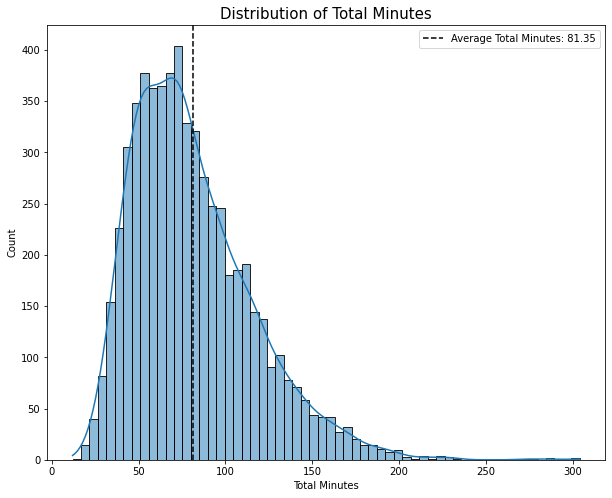

In [81]:
# Distribution of output
plt.figure(figsize=(10,8))
sns.histplot(df_orders_train['total_minutes'], kde=True)
plt.axvline(df_submission_predictions.total_minutes.mean(), color='k', ls='--', linestyle='dashed',
            label=f'Average Total Minutes: {np.round(df_submission_predictions.total_minutes.mean(),2)}')
plt.xlabel("Total Minutes")
plt.title('Distribution of Total Minutes',fontsize=15)
plt.legend()
plt.show()

This is very similar to the distribution of training and testing sets.

# 4) Exporting Model

In [74]:
# model 
filename_model = 'model.sav'
pickle.dump(model_nb, open(os.path.join(MODEL_PATH, filename_model), 'wb'))
# feature engineering pipe
filename_feature_engineering_pipe = 'feature_engineering_pipe.sav'
pickle.dump(pipe_feature_engineering, open(os.path.join(MODEL_PATH, filename_feature_engineering_pipe), 'wb'))


# Next Steps/ Recommendations

- Data: Despite We had a good MAPE in our models, It's very posible to improve this performance by adding more samples and features, as We can see in the learning curve pattern. Also, It would be really useful to acquire data from the other days of the week and different months as well. When It comes to which features to add, I would say:
    - Weather conditions (real time)
    - Traffic conditions (real time)
    - Vehicle (bike, car, motorcycle)
- Models: The modeling step can be improved a lot. We could think more about feature engineering, for example.
- Monitoring: The application if Put into production enviroment, should be able to produce responses in real time. As the scenario evolves, It would be important to create some dashboards and alarms in case of weird predictions and anomalies, as well as to monitor the performance, concept and data drif.
